In [12]:
DATA_PATH = ['data',]
### csv must be  id|xxx|xxx|nose|LEye.......

alphaI2W = [ "nose","LEye","REye","LEar","REar","LShoulder","RShoulder", "LElbow","RElbow",\
"LWrist", "RWrist","LHip","RHip", "LKnee","Rknee", "LAnkle","RAnkle"]

tagI2W = ["Fall","Stand", "Tie"] # 9
tagW2I = {w:i for i,w in enumerate(tagI2W)}

In [13]:
tagW2I

{'Fall': 0, 'Stand': 1, 'Tie': 2}

In [14]:
alphaI2W

['nose',
 'LEye',
 'REye',
 'LEar',
 'REar',
 'LShoulder',
 'RShoulder',
 'LElbow',
 'RElbow',
 'LWrist',
 'RWrist',
 'LHip',
 'RHip',
 'LKnee',
 'Rknee',
 'LAnkle',
 'RAnkle']

In [29]:
import os
import pandas as pd 
import numpy as np
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

parpath = os.path.dirname(os.getcwd())
sys.path.append(parpath)

_=torch.manual_seed(42)

In [28]:
N_EPOCHS = 3000
BATCH_SIZE = 32
SHUFFLE = True
INPUT_DIM = 34
CLASS_NUM = len(tagI2W)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from actRec.models import dnnSingle
model = dnnSingle(INPUT_DIM,CLASS_NUM,initrange=1.5).to(device)
criterion = nn.CrossEntropyLoss().to(device)

In [25]:
from dataset import SinglePoseDataset
from actRec.F import normalize_min_

class ReadPoseDataset():
    def __init__(self, csvdirpath,use_large=True):
        data  = []
        label = []
        for csv_dir_path in csvdirpath:
            csvlist = os.listdir(csv_dir_path)
            for FileName in csvlist:
                #verifies file ends with .csv extension
                if(os.path.isdir(FileName)):continue
                if(os.path.splitext(FileName)[1] != '.csv'):continue    
                CSVFile = os.path.join(csv_dir_path,FileName)
                #read csv file
                KP_df = pd.read_csv(CSVFile)
                #skipping (0-3) colomns , return values of all rows and columns from 4 to last
                features = KP_df.iloc[:,4:].values
                #return values of pose_class 
                pose_class = KP_df['pos_class'].values
                #normalize keypoints 
                normalize_min_(features)
                
                for feats, lbs in zip(features, pose_class):
                    data.append(feats)
                    label.append(tagW2I[lbs])

        self.dataset = np.array(data)
        self.labels  = np.array(label)

    def __len__(self):
        return len(self.dataset)
    
    def split(self,test_size=0.2, random_state=42):
        X_train, X_test, Y_train, Y_test = train_test_split(self.dataset, self.labels, test_size=test_size, random_state=random_state)
        return SinglePoseDataset(X_train,Y_train),SinglePoseDataset(X_test,Y_test)

In [27]:
ReadPoseDataset(DATA_PATH).__len__()

36985

In [34]:
train_data,test_data = ReadPoseDataset(DATA_PATH).split()
train_data.X.shape, train_data.Y.shape, test_data.X.shape, test_data.Y.shape

((29588, 34), (29588,), (7397, 34), (7397,))

In [11]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=SHUFFLE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE,shuffle=SHUFFLE)

In [12]:
def model_eval(batch):
    label_ = torch.LongTensor(batch['label']).to(device)
    input_= batch['data'].to(device)
    
    out = model(input_) # data,datalen
    loss = criterion(out, label_)
    
    batch_acc = (out.argmax(1) == label_).sum().item()
    return loss,batch_acc

In [13]:
# optimizer = optim.SGD(model.parameters(), lr=0.05)
optimizer = optim.Adadelta(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.4)

In [14]:
import procession as pc
import time
_epoch = -1

t = time.localtime(time.time())
timestr = '%d-%d-%d_%d-%d'%(t[0],t[1],t[2],t[3],t[4])
savepath = 'model/act_dnnSingle%d_'%len(tagI2W)
savepath +=timestr

os.chdir(parpath)
if not os.path.exists(savepath):
    os.makedirs(savepath)

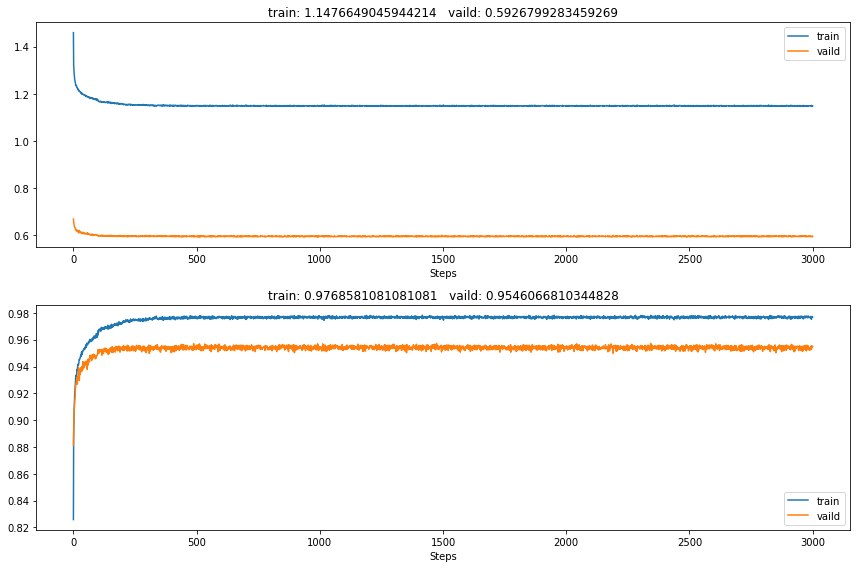


 Mon Dec 28 23:23:28 2020
Epoch: 3000  | time in 0 minutes, 2 seconds
	Loss: 1.1477(train)	|	Acc: 97.7%(train)
	Loss: 0.5927(valid)	|	Acc: 95.5%(valid)
SAVING EPOCH 3000


In [15]:
import hiddenlayer as hl

train_his = hl.History()
vaild_his = hl.History()
canvas1 = hl.Canvas()
for epoch in range(_epoch+1,N_EPOCHS+1):
    start_time = time.time()
    train_loss, train_acc = pc.train_epoch(model,train_loader,model_eval,optimizer,scheduler,BATCH_SIZE)
    valid_loss, valid_acc = pc.evaluate(model,test_loader,model_eval,BATCH_SIZE)
    train_his.log(epoch, loss=train_loss, accuracy=train_acc)
    vaild_his.log(epoch, loss=valid_loss, accuracy=valid_acc)
    with canvas1:
        canvas1.draw_plot([train_his["loss"], vaild_his["loss"]],labels=["train", "vaild"])
        canvas1.draw_plot([train_his["accuracy"], vaild_his["accuracy"]],labels=["train", "vaild"])
    pc.print_train_info(start_time,epoch,train_loss,train_acc,valid_loss,valid_acc)
    _epoch=epoch
    info =  {'train_loss':train_loss,'train_acc':train_acc,'valid_loss':valid_loss,'valid_acc':valid_acc}
    if epoch % 500 ==0 and epoch != 0: 
        pc.save_model_with_info(model,optimizer,tagI2W,info,epoch,savepath)